In [1]:
import numpy as np
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv, N_syl, N_HVC_per_syl = 300, 5, 4
N_HVC = N_syl * N_HVC_per_syl
conn_prob = 1

In [3]:
peak_rate, kernel_width = 150, 10

In [4]:
T_rend = 1000 # Each rendition
N_rend = 11 # Number of renditions
T_burn = 50 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(N_syl, N_Aiv))
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend)
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=False) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
# ( Number of HVC neurons , Number of renditions )
burst_ts = np.linspace(tsyl_start[0,:], tsyl_end[-1,:], num=N_HVC, endpoint=False)
burst_ts += T_rend/(N_syl+1) * 0.1 # a little delay 
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

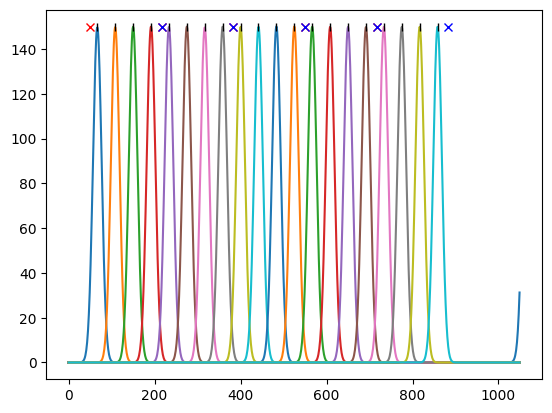

In [7]:
plt.plot(rH[:T_rend+T_burn])
plt.plot(tsyl_start[:,0], np.zeros(N_syl) + peak_rate, 'x', c='r')
plt.plot(tsyl_end[:,0], np.zeros(N_syl) + peak_rate, 'x', c='b')
plt.plot(burst_ts[:,0], np.zeros(N_HVC) + peak_rate, '|', c='k')

In [8]:
# (T, N_Aiv)
aud = generate_discrete_aud(T, N_Aiv, tsyl_start.T.flatten(), tsyl_end.T.flatten(), 
                            np.tile(syl, (N_rend, 1)))

In [9]:
rmax, s, th = 100, 1, 4
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [10]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [11]:
w0_mean, w0_std = 1/N_HVC, 0.1/N_HVC
JEE, JEI, JIE, JII = np.zeros(4) # Major difference
tau_Aiv, tau_I, dt = 20, 10, 1

net = Aiv(N_Aiv, N_HVC, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
          tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.1, ext_I, bilin_hebb,
            lr=-2e-7, w0_mean=w0_mean, tau_w=2e7)
rA, rI, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


(0.0, 1000.0)

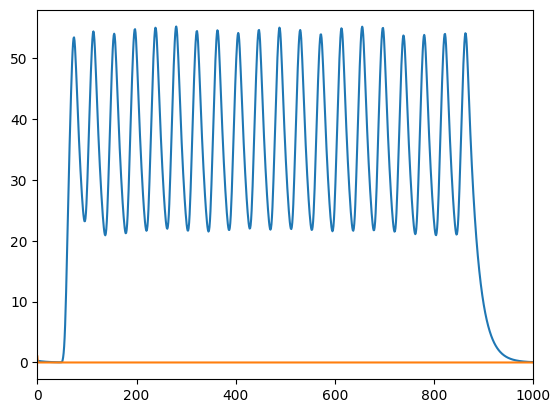

In [12]:
plt.plot(rA.mean(axis=1))
plt.plot(rI)
plt.xlim([0, 1000])

[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

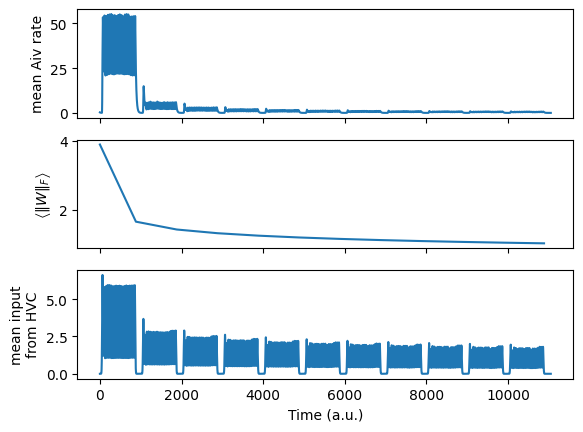

In [13]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [14]:
W_syl_corrs = [correlation(_.T, syl, lambda x: x) for _ in Ws]

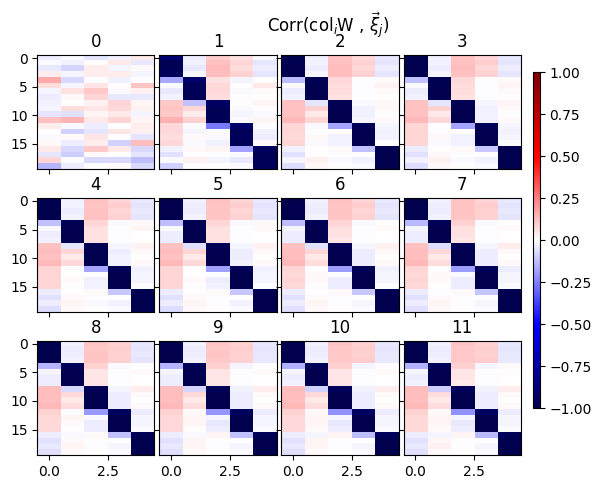

In [15]:
fig, ax = plt.subplots(3, 4, sharex='all', sharey='all')
ax = ax.flatten()
for i, wsc in enumerate(W_syl_corrs):
    if i >= len(ax):
        break
    im = ax[i].imshow(wsc, vmax=1, vmin=-1, cmap='seismic', aspect='auto')
    ax[i].set_title(i)

fig.suptitle(r'Corr(col$_i$W , $\vec\xi_j$)')
fig.tight_layout(pad=0.1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

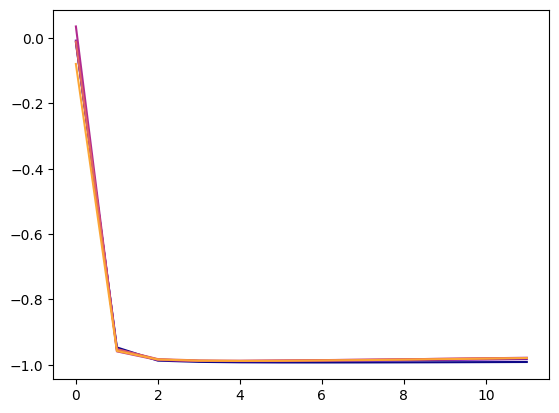

In [16]:
cmap = colormaps.get_cmap('plasma')
for i in range(N_syl):
    j, k = N_HVC_per_syl * i, N_HVC_per_syl * (i + 1)
    plt.plot(list(map(lambda x: x[j:k,i].mean(), W_syl_corrs)), c=cmap(i/N_syl))

1.699002524373207

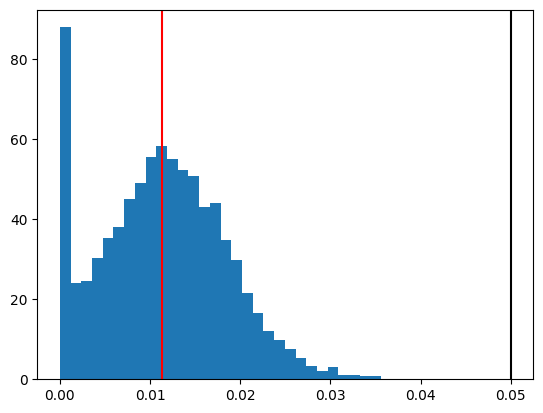

In [17]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')
Ws[-1].mean() * peak_rate

## Test Model with Unmatched Auditory Feedback

In [18]:
N_rend_test = 5
T_test = T_burn + T_rend * N_rend_test
t_test_start, t_test_end = tsyl_start[:,:N_rend_test], tsyl_end[:,:N_rend_test]
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH_ = generate_HVC(T_test, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
Aiv0, I0, ext_I, noise = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0, 0

### Mismatch with completely independent patterns

In [19]:
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_test, N_Aiv, t_test_start.T.flatten(), 
                               t_test_end.T.flatten(), np.tile(syl[idx_si], (N_rend_test, 1)))
aud_sp = generate_discrete_aud(T_test, N_Aiv, t_test_start.T.flatten(), 
                               t_test_end.T.flatten(), np.tile(syl_sp, (N_rend_test, 1)))

In [20]:
# plasticity function is None and lr is 0 by default
test0 = net.sim(Aiv0, I0, rH_, aud[:T_test], [], T_test, dt, noise, ext_I)
test_si = net.sim(Aiv0, I0, rH_, aud_si, [], T_test, dt, noise, ext_I)
test_sp = net.sim(Aiv0, I0, rH_, aud_sp, [], T_test, dt, noise, ext_I)
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2] # just want rA and rI

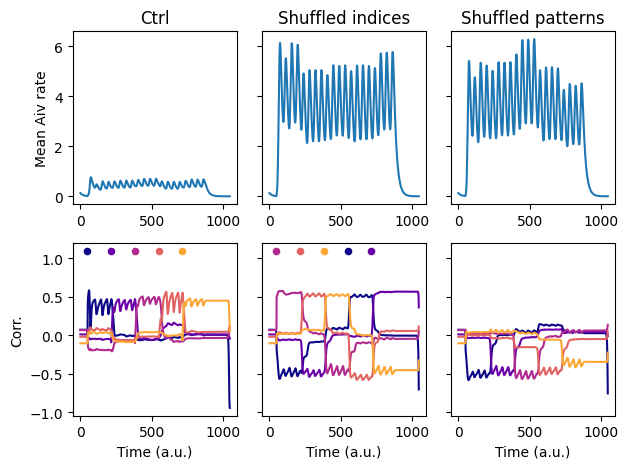

In [21]:
labels = ('Ctrl', 'Shuffled indices', 'Shuffled patterns')
cmap = colormaps.get_cmap('plasma')
fig, ax = plt.subplots(2, 3, sharey='row')
for i, (test, l) in enumerate(zip((test0, test_si, test_sp), labels)):
    corr = correlation(test[0][:T_burn+T_rend], syl, lambda x: x)
    # ax[0,i].plot(test[1][:], test[0].mean(axis=1)[:], lw=1)
    ax[0,i].plot(test[0][:T_burn+T_rend].mean(axis=1)[:])
    # ax[0,i].plot(test[1][:]) # rI is already the mean
    ax[0,i].set(title=l)
    ax[1,i].set(xlabel='Time (a.u.)')
    for j in range(corr.shape[1]):
        ax[1,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))

for i, j in enumerate(idx_si):
    c1, c2 = cmap(i/len(idx_si)), cmap(j/len(idx_si))
    ax[1,0].scatter(tsyl_start[i,0], 1.1, color=c1, s=20)
    ax[1,1].scatter(tsyl_start[i,0], 1.1, color=c2, s=20)
ax[0,0].set(ylabel='Mean Aiv rate')
ax[1,0].set(ylabel='Corr.')
fig.tight_layout()

[(-5.0, 20.0), Text(0.5, 0, 'Input'), Text(0, 0.5, 'Rate')]

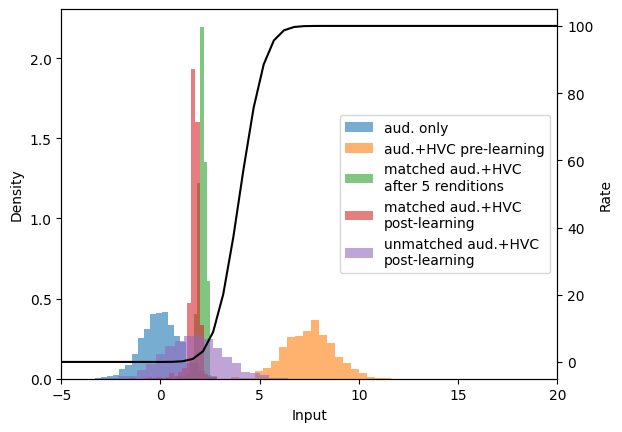

In [22]:
fig, ax = plt.subplots()
a = 0.6
ax = [ax, ax.twinx()]
kwargs = dict(bins=20, density=True, alpha=a)
ax[0].hist(syl.flatten(), bins=20, density=True, alpha=a, 
           label='aud. only')
ax[0].hist((syl+Ws[0][:,::N_HVC_per_syl].T*peak_rate).flatten(), 
           label='aud.+HVC pre-learning', **kwargs)
ax[0].hist((syl+Ws[5][:,::N_HVC_per_syl].T*peak_rate).flatten(),
           label='matched aud.+HVC\nafter 5 renditions', **kwargs)
ax[0].hist((syl+Ws[-1][:,::N_HVC_per_syl].T*peak_rate).flatten(),
           label='matched aud.+HVC\npost-learning', **kwargs)
ax[0].hist((syl[idx_si]+Ws[-1][:,::N_HVC_per_syl].T*peak_rate).flatten(),
           label='unmatched aud.+HVC\npost-learning', **kwargs)
_ = np.linspace(-5, 20)
ax[0].set(xlim=_[[0,-1]], xlabel='Input', ylabel='Density')
ax[0].legend(loc='right')
ax[1].plot(_, phi(_), c='k')
ax[1].set(xlim=_[[0,-1]], xlabel='Input', ylabel='Rate')

### Mismatch with perturbed patterns

In [23]:
rhos = np.linspace(1, 0, num=11) # corr with the pattern
tests, ovlps, corrs = [], [], []

for rho in rhos:
    perturb = rng.standard_normal(size=syl.shape)
    syl_ = syl.copy()
    # syl_ = syl * rho + np.sqrt(1 - rho**2) * perturb
    # In case of temporal summation
    syl_[[0,2,4]] = syl[[0,2,4]] * rho + np.sqrt(1 - rho**2) * perturb[[0,2,4]]
    aud_ = generate_discrete_aud(T_test, N_Aiv, t_test_start.T.flatten(), 
                                 t_test_end.T.flatten(), np.tile(syl_, (N_rend_test, 1)))
    tests.append(net.sim(Aiv0, I0, rH_, aud_, [], T_test, dt, noise, ext_I))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], syl, lambda x: x))

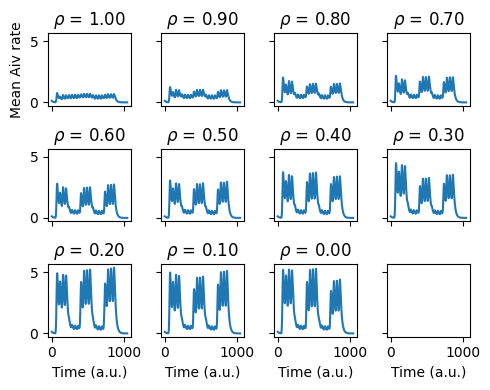

In [24]:
fig, ax = plt.subplots(3, 4, sharey='all', sharex='all', figsize=(5, 4))
for i in range(ax.shape[1]):
    ax[-1,i].set(xlabel='Time (a.u.)')
ax = ax.flatten()
for i, (rho, test) in enumerate(zip(rhos, tests)):
    # ax[i].plot(test[1][:], test[0].mean(axis=1)[:], lw=1)
    ax[i].plot(test[0][:T_burn+T_rend].mean(axis=1))
    # ax[i].plot(test[1][:]) # rI is already the mean
    ax[i].set(title=r'$\rho$' + ' = %.2f' % rho)
    
ax[0].set(ylabel='Mean Aiv rate')
fig.tight_layout()

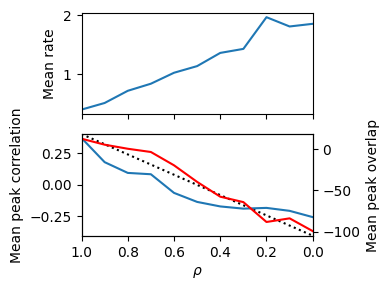

In [25]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
ax = [*ax, ax[1].twinx()]
ax[0].plot(rhos, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot([0, 1], [1, 0], transform=ax[1].transAxes, ls=':', color='k')
ax[1].plot(rhos, list(map(lambda x: x.sum(axis=1).mean(), corrs)))
ax[2].plot(rhos, list(map(lambda x: x.mean(), ovlps)), color='r')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(ylabel='Mean peak correlation', xlabel=r'$\rho$', xlim=[1, 0], ylim=[-_, _])
ax[2].set(ylabel='Mean peak overlap')
fig.tight_layout()

## Response to additive Gaussian noise

In [26]:
gammas = np.linspace(0, 1, num=11) # corr with the pattern
tests, ovlps, corrs = [], [], []

for gamma in gammas:
    perturb = rng.standard_normal(size=syl.shape)
    perturb[[1,3]] = 0 # In case of temporal summation
    syl_ = syl + gamma * perturb 
    aud_ = generate_discrete_aud(T_test, N_Aiv, t_test_start.T.flatten(), 
                                 t_test_end.T.flatten(), np.tile(syl_, (N_rend_test, 1)))
    tests.append(net.sim(Aiv0, I0, rH_, aud_, [], T_test, dt, noise, ext_I))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], syl, lambda x: x))

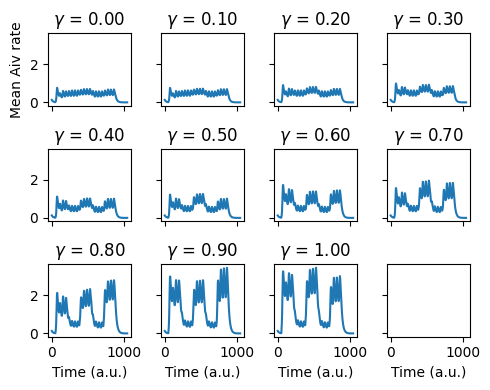

In [27]:
fig, ax = plt.subplots(3, 4, sharey='all', sharex='all', figsize=(5, 4))
for i in range(ax.shape[1]):
    ax[-1,i].set(xlabel='Time (a.u.)')
ax = ax.flatten()
for i, (gamma, test) in enumerate(zip(gammas, tests)):
    # ax[i].plot(test[1][:], test[0].mean(axis=1)[:], lw=1)
    ax[i].plot(test[0][:T_burn+T_rend].mean(axis=1))
    # ax[i].plot(test[1][:]) # rI is already the mean
    ax[i].set(title=r'$\gamma$' + ' = %.2f' % gamma)
    
ax[0].set(ylabel='Mean Aiv rate')
fig.tight_layout()

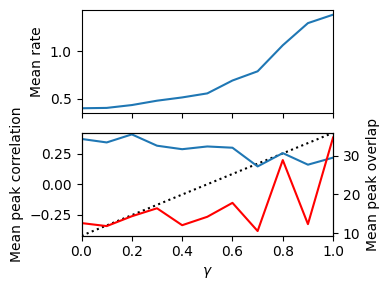

In [28]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
ax = [*ax, ax[1].twinx()]
ax[0].plot(gammas, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, ls=':', color='k')
ax[1].plot(gammas, list(map(lambda x: x.sum(axis=1).mean(), corrs)))
ax[2].plot(gammas, list(map(lambda x: x.mean(), ovlps)), color='r')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(ylabel='Mean peak correlation', xlabel=r'$\gamma$', xlim=[0, 1], ylim=[-_, _])
ax[2].set(ylabel='Mean peak overlap')
fig.tight_layout()

## Notes

### "transfer function" between perturbation strength to y and error code?
- The variability in the error code?
- Perturb around y
- Population structure to replay
- What signature we can get from the model?
### Can we verify in vitro?

### covariance in perturbation instead of N(0,1)? Different $\epsilon$ realization? 
### Essentially, how do we map variability in the input to the responses? Is it a sparse error code?